# Sentiment Analysis: Twitter vs Amazon Review Data

This notebook compares different sentiment analysis models on Twitter and Amazon datasets.

In [54]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\XT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\XT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\XT\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Loading

In [55]:
amazon_data = pd.read_csv('amazon_reviews.csv')
amazon_data.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0


In [56]:
amazon_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            4915 non-null   int64  
 1   reviewerName          4914 non-null   object 
 2   overall               4915 non-null   float64
 3   reviewText            4914 non-null   object 
 4   reviewTime            4915 non-null   object 
 5   day_diff              4915 non-null   int64  
 6   helpful_yes           4915 non-null   int64  
 7   helpful_no            4915 non-null   int64  
 8   total_vote            4915 non-null   int64  
 9   score_pos_neg_diff    4915 non-null   int64  
 10  score_average_rating  4915 non-null   float64
 11  wilson_lower_bound    4915 non-null   float64
dtypes: float64(3), int64(6), object(3)
memory usage: 460.9+ KB


In [57]:
amazon_data.isnull().sum()

Unnamed: 0              0
reviewerName            1
overall                 0
reviewText              1
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
dtype: int64

In [58]:
def categorize_sentiment(row):
    if row['overall'] > 3:
        return 'positive'
    elif row['overall'] < 3:
        return 'negative'
    else:
        # Check if the review text contains any sentiment words
        text = row['reviewText'].lower()
        positive_words = ['good', 'great', 'excellent', 'amazing', 'love', 'like', 'recommend', 'awesome', 'best',
                          'wonderful', 'well', 'perfect', 'happy', 'satisfied', 'ideal', 'superb', 'fantastic', 'outstanding']
        negative_words = ['bad', 'poor', 'terrible', 'awful', 'hate', 'dislike', 'disappoint', 'disappointed', 
                          'regret', 'unhappy', 'problem', 'issue', 'mistake', 'waste', 'wasted', 'return', 'refund']
        irrelevant_words = ['ok', 'okay', 'fine', 'average', 'alright', 'satisfactory', 'neutral', 
                            'no opinion', 'no feelings', 'no sentiment', 'no emotion', 'no attitude']
        
        if any(word in text for word in positive_words):
            return 'positive'
        elif any(word in text for word in negative_words):
            return 'negative'
        else:
            return 'irrelevant'

# Apply the function to create the 'type' column
amazon_data['type'] = amazon_data.apply(categorize_sentiment, axis=1)

# Display the first few rows to verify the new column
amazon_data.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,type
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0,positive
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0,positive
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0,positive
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0,positive
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0,positive


In [59]:
from copy import deepcopy
amazon_data1 = deepcopy(amazon_data)
amazon_data1.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,type
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0,positive
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0,positive
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0,positive
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0,positive
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0,positive


In [60]:
amazon_data1['type'].value_counts()

type
positive      4526
negative       353
irrelevant      36
Name: count, dtype: int64

In [61]:
# Fill NaNs with empty string
amazon_data1['reviewText'] = amazon_data1['reviewText'].fillna('')

amazon_data1['lower'] = amazon_data1['reviewText'].str.lower()
amazon_data1['lower'] = amazon_data1['lower'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
amazon_data1['lower'] = amazon_data1['lower'].apply(lambda x: re.sub(r'\d+', '', x))
amazon_data1['lower'] = [str(i).strip() for i in amazon_data1['lower']]
amazon_data1.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,type,lower
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0,positive,no issues
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0,positive,purchased this for my device it worked as adve...
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0,positive,it works as expected i should have sprung for ...
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0,positive,this think has worked out greathad a diff bran...
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0,positive,bought it with retail packaging arrived legit ...


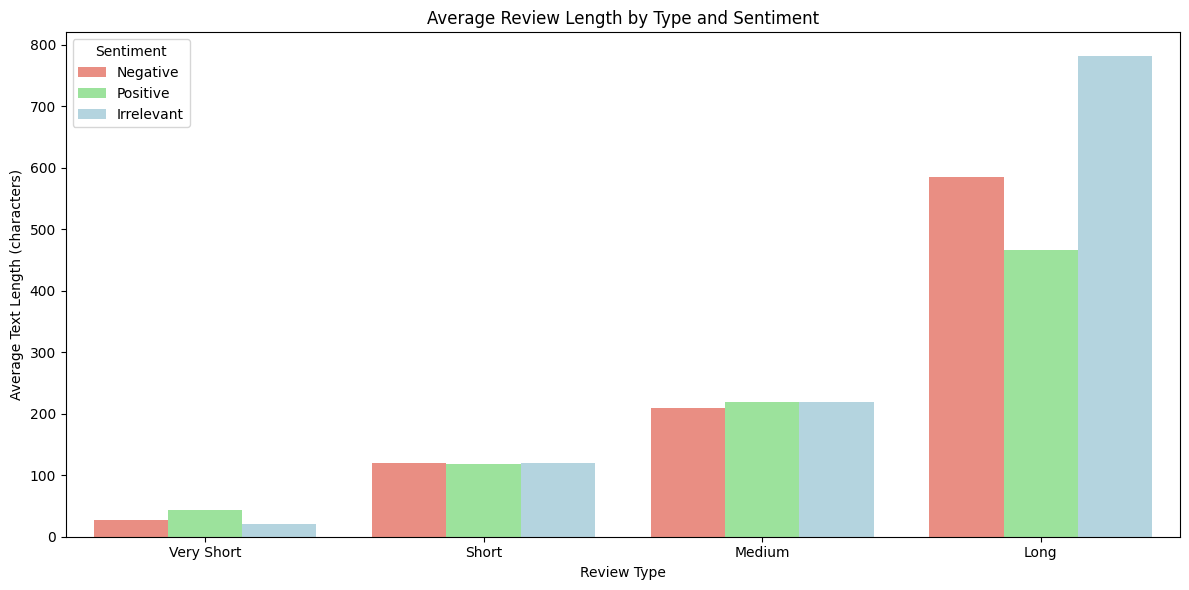

In [62]:
# Calculate text length for each review
amazon_data['reviewText'] = amazon_data['reviewText'].fillna('')  # Fill NaNs with empty string
amazon_data['text_length'] = amazon_data['reviewText'].apply(len)

# Define bins and labels for review length
bins = [0, 50, 150, 300, np.inf]
labels = ['Very Short', 'Short', 'Medium', 'Long']
amazon_data['review_type'] = pd.cut(amazon_data['text_length'], bins=bins, labels=labels)

# Ensure sentiment column exists
if 'sentiment' not in amazon_data.columns:
    amazon_data['sentiment'] = (amazon_data['overall'] > 3).astype(int)

# Create a grouped bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='review_type', y='text_length', hue='type', 
           data=amazon_data, palette=['salmon', 'lightgreen', 'lightblue'],
           ci=None)  # No confidence intervals

plt.title('Average Review Length by Type and Sentiment')
plt.xlabel('Review Type')
plt.ylabel('Average Text Length (characters)')
plt.legend(title='Sentiment', labels=['Negative', 'Positive', 'Irrelevant'])
plt.tight_layout()
plt.show()

In [63]:
# Perform tokenization
token = [word_tokenize(str(word)) for word in amazon_data1['lower']]
token[:5]

[['no', 'issues'],
 ['purchased',
  'this',
  'for',
  'my',
  'device',
  'it',
  'worked',
  'as',
  'advertised',
  'you',
  'can',
  'never',
  'have',
  'too',
  'much',
  'phone',
  'memory',
  'since',
  'i',
  'download',
  'a',
  'lot',
  'of',
  'stuff',
  'this',
  'was',
  'a',
  'no',
  'brainer',
  'for',
  'me'],
 ['it',
  'works',
  'as',
  'expected',
  'i',
  'should',
  'have',
  'sprung',
  'for',
  'the',
  'higher',
  'capacity',
  'i',
  'think',
  'its',
  'made',
  'a',
  'bit',
  'cheesier',
  'than',
  'the',
  'earlier',
  'versions',
  'the',
  'paint',
  'looks',
  'not',
  'as',
  'clean',
  'as',
  'before'],
 ['this',
  'think',
  'has',
  'worked',
  'out',
  'greathad',
  'a',
  'diff',
  'bran',
  'gb',
  'card',
  'and',
  'if',
  'went',
  'south',
  'after',
  'monthsthis',
  'one',
  'has',
  'held',
  'up',
  'pretty',
  'well',
  'since',
  'i',
  'had',
  'my',
  's',
  'now',
  'on',
  'my',
  'note',
  'update',
  'ive',
  'had',
  'this',
 

In [64]:
# Remove stopwords from the tokenized words
stop_words = set(stopwords.words('english'))
token_no_stopwords = [[word for word in words if word not in stop_words] for words in token]
token_no_stopwords[:5]

[['issues'],
 ['purchased',
  'device',
  'worked',
  'advertised',
  'never',
  'much',
  'phone',
  'memory',
  'since',
  'download',
  'lot',
  'stuff',
  'brainer'],
 ['works',
  'expected',
  'sprung',
  'higher',
  'capacity',
  'think',
  'made',
  'bit',
  'cheesier',
  'earlier',
  'versions',
  'paint',
  'looks',
  'clean'],
 ['think',
  'worked',
  'greathad',
  'diff',
  'bran',
  'gb',
  'card',
  'went',
  'south',
  'monthsthis',
  'one',
  'held',
  'pretty',
  'well',
  'since',
  'note',
  'update',
  'ive',
  'months',
  'zero',
  'issues',
  'since',
  'transferred',
  'note',
  'note',
  'card',
  'reliable',
  'solidcheers'],
 ['bought',
  'retail',
  'packaging',
  'arrived',
  'legit',
  'orange',
  'envelope',
  'english',
  'version',
  'asian',
  'like',
  'picture',
  'shows',
  'arrived',
  'quickly',
  'bought',
  'retail',
  'packaging',
  'htc',
  'one',
  'sv',
  'lg',
  'optimus',
  'cards',
  'working',
  'order',
  'probably',
  'best',
  'price',


In [65]:
# Preprocess the text data
amazon_data1['preprocessed_text'] = amazon_data1['lower'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))

# Create a new CountVectorizer instance without specifying the tokenizer parameter
bow_counts = CountVectorizer(stop_words='english', ngram_range=(1, 1))
bow_counts

CountVectorizer(stop_words='english')

In [66]:
# Fit and transform the preprocessed text data
bow_data = bow_counts.fit_transform(amazon_data1['preprocessed_text'])
bow_data

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 96531 stored elements and shape (4915, 9510)>

In [67]:
amazon_data1_train, amazon_data1_test = train_test_split(amazon_data1, 
                                                         test_size=0.2,
                                                         random_state=42)

X_amazon_data1_train = amazon_data1_train['preprocessed_text']
X_amazon_data1_test = amazon_data1_test['preprocessed_text']

In [68]:
y_amazon_data1_train = amazon_data1_train['type']
y_amazon_data1_test = amazon_data1_test['type']

# Initialize the Logistic Regression model
logistic_model = LogisticRegression(C=0.5, 
                                    max_iter=300,
                                    solver='liblinear')

# Initialize the Multinomial Naive Bayes model
nb_model = MultinomialNB(class_prior=None,
                         fit_prior=True,
                         alpha=1.0)

# Initialize the Random Forest Classifier model
rf_model = RandomForestClassifier(n_estimators=100, 
                                  random_state=42)

# Initialize the Linear Support Vector Classifier model
svm_model = LinearSVC(C=1.0, 
                      max_iter=1000)

# Initialize the TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english', 
                        ngram_range=(1, 1))

In [69]:
# Fit and transform the training data for Logistic Regression
X_train_logistic = tfidf.fit_transform(X_amazon_data1_train)
X_test_logistic = tfidf.transform(X_amazon_data1_test)

# Fit and transform the training data for Multinomial Naive Bayes
X_train_nb = tfidf.fit_transform(X_amazon_data1_train)
X_test_nb = tfidf.transform(X_amazon_data1_test)

# Fit and transform the training data for Random Forest Classifier
X_train_rf = tfidf.fit_transform(X_amazon_data1_train)
X_test_rf = tfidf.transform(X_amazon_data1_test)

# Fit and transform the training data for Linear Support Vector Classifier
X_train_svm = tfidf.fit_transform(X_amazon_data1_train)
X_test_svm = tfidf.transform(X_amazon_data1_test)

In [70]:
# Fit the Logistic Regression model with the training data
logistic_model.fit(X_train_logistic, y_amazon_data1_train)

# Evaluate the accuracy of Logistic Regression model performance
accuracy_scores = accuracy_score(y_amazon_data1_test, logistic_model.predict(X_test_logistic))
precision_scores = precision_score(y_amazon_data1_test, logistic_model.predict(X_test_logistic), average='weighted')
recall_scores = recall_score(y_amazon_data1_test, logistic_model.predict(X_test_logistic), average='weighted')
f1_scores = f1_score(y_amazon_data1_test, logistic_model.predict(X_test_logistic), average='weighted')

print('Logistic Regression Model')
print('Accuracy:', f'{accuracy_scores:.2f}')
print('Precision:', f'{precision_scores:.2f}')
print('Recall:', f'{recall_scores:.2f}')
print('F1 Score:', f'{f1_scores:.2f}')

Logistic Regression Model
Accuracy: 0.92
Precision: 0.92
Recall: 0.92
F1 Score: 0.88


In [71]:
# Fit the Multinomial Naive Bayes model with the training data
nb_model.fit(X_train_nb, y_amazon_data1_train)

# Evaluate the accuracy of Multinomial Naive Bayes model performance
accuracy_scores = accuracy_score(y_amazon_data1_test, nb_model.predict(X_test_nb))
precision_scores = precision_score(y_amazon_data1_test, nb_model.predict(X_test_nb),
                                   average='weighted')
recall_scores = recall_score(y_amazon_data1_test, nb_model.predict(X_test_nb), 
                             average='weighted')
f1_scores = f1_score(y_amazon_data1_test, nb_model.predict(X_test_nb), 
                     average='weighted')

print('Multinomial Naive Bayes Model')
print('Accuracy:', f'{accuracy_scores:.2f}')
print('Precision:', f'{precision_scores:.2f}')
print('Recall:', f'{recall_scores:.2f}')
print('F1 Score:', f'{f1_scores:.2f}')

Multinomial Naive Bayes Model
Accuracy: 0.92
Precision: 0.84
Recall: 0.92
F1 Score: 0.88


In [72]:
# Fit the Random Forest Classifier model with the training data
rf_model.fit(X_train_rf, y_amazon_data1_train)

# Evaluate the accuracy of Random Forest Classifier model performance
accuracy_scores = accuracy_score(y_amazon_data1_test, rf_model.predict(X_test_rf))
precision_scores = precision_score(y_amazon_data1_test, rf_model.predict(X_test_rf),
                                   average='weighted')
recall_scores = recall_score(y_amazon_data1_test, rf_model.predict(X_test_rf), 
                             average='weighted')
f1_scores = f1_score(y_amazon_data1_test, rf_model.predict(X_test_rf),
                     average='weighted')

print('Random Forest Classifier Model')
print('Accuracy:', f'{accuracy_scores:.2f}')
print('Precision:', f'{precision_scores:.2f}')
print('Recall:', f'{recall_scores:.2f}')
print('F1 Score:', f'{f1_scores:.2f}')

Random Forest Classifier Model
Accuracy: 0.92
Precision: 0.92
Recall: 0.92
F1 Score: 0.89


In [73]:
# Fit the Linear Support Vector Classifier model with the training data
svm_model.fit(X_train_svm, y_amazon_data1_train)

# Evaluate the accuracy of Linear Support Vector Classifier model performance
accuracy_scores = accuracy_score(y_amazon_data1_test, svm_model.predict(X_test_svm))
precision_scores = precision_score(y_amazon_data1_test, svm_model.predict(X_test_svm),
                                   average='weighted')
recall_scores = recall_score(y_amazon_data1_test, svm_model.predict(X_test_svm),
                             average='weighted')
f1_scores = f1_score(y_amazon_data1_test, svm_model.predict(X_test_svm),
                     average='weighted')

print('Linear Support Vector Classifier Model')
print('Accuracy:', f'{accuracy_scores:.2f}')
print('Precision:', f'{precision_scores:.2f}')
print('Recall:', f'{recall_scores:.2f}')
print('F1 Score:', f'{f1_scores:.2f}')

Linear Support Vector Classifier Model
Accuracy: 0.95
Precision: 0.94
Recall: 0.95
F1 Score: 0.94


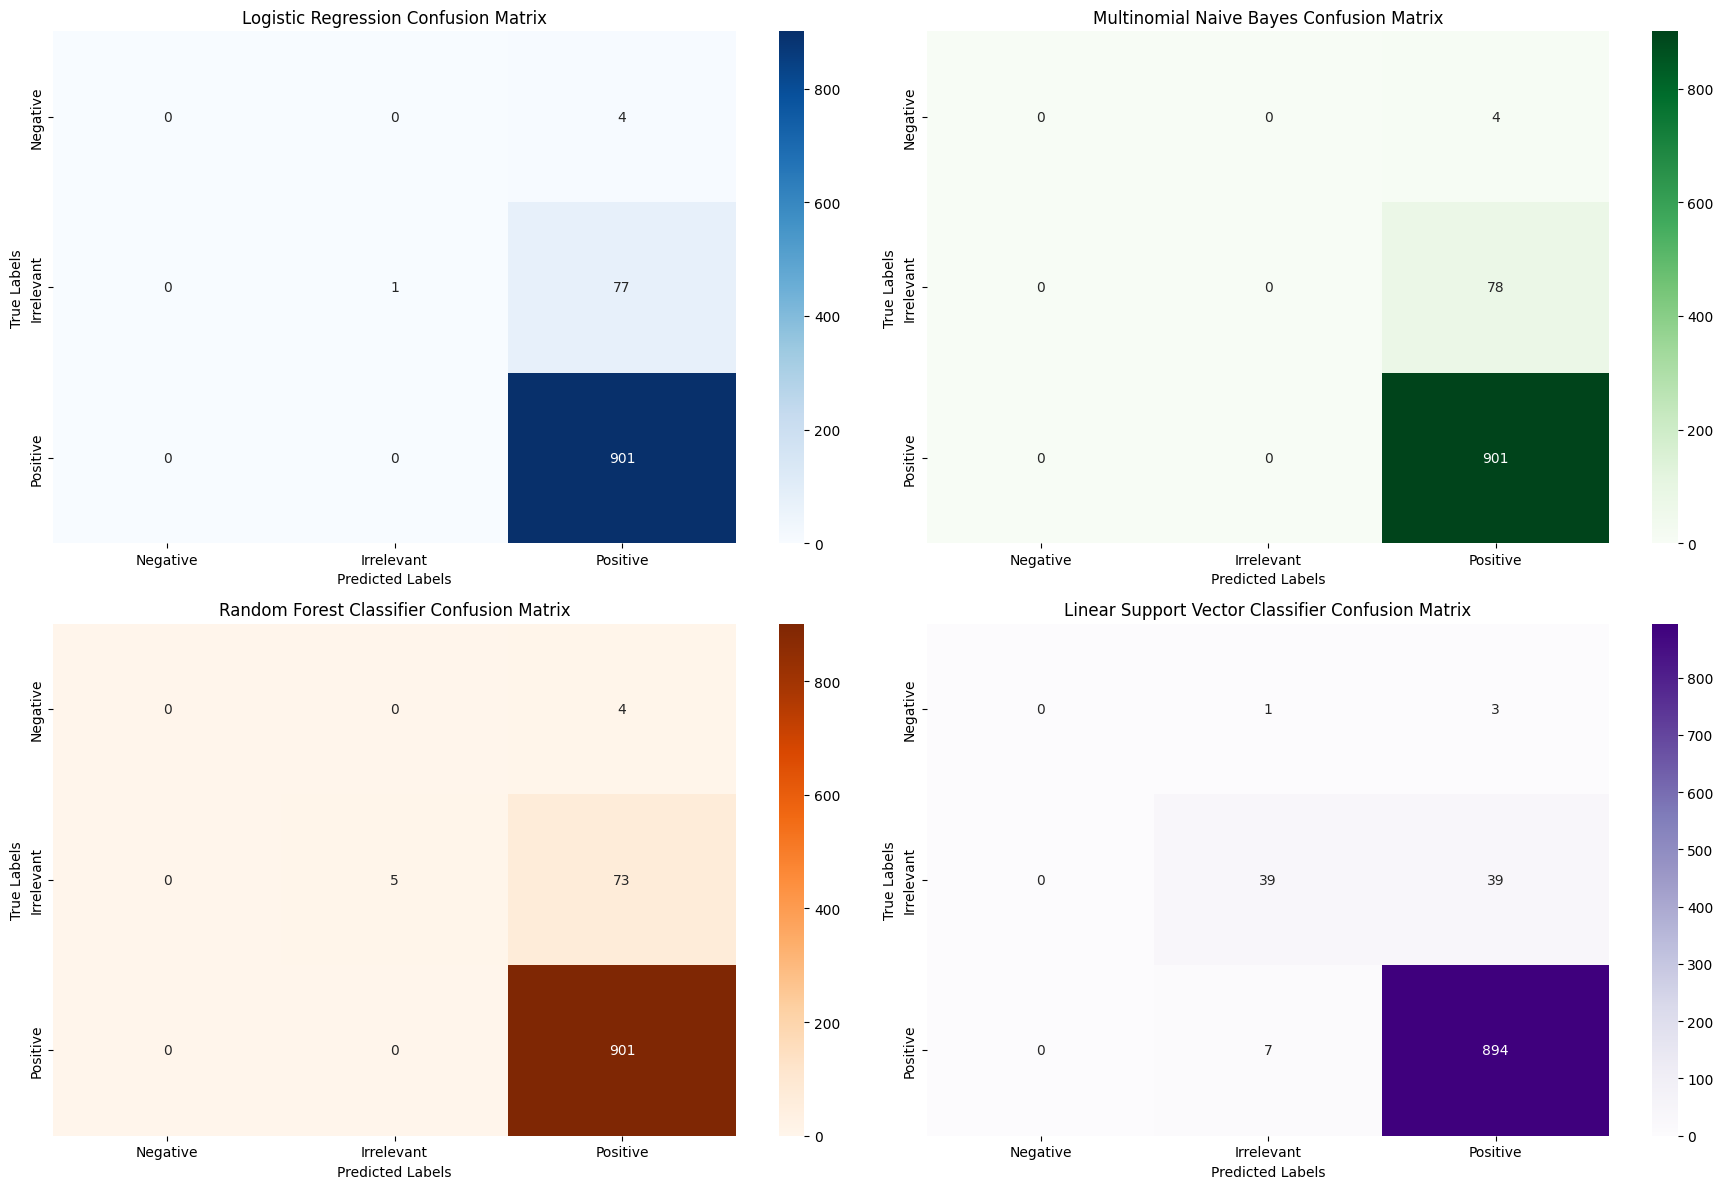

In [74]:
# Create a confusion matrix for Logistic Regression model
logistic_confusion_matrix = confusion_matrix(y_amazon_data1_test, logistic_model.predict(X_test_logistic))

# Create a confusion matrix for Multinomial Naive Bayes model
nb_confusion_matrix = confusion_matrix(y_amazon_data1_test, nb_model.predict(X_test_nb))

# Create a confusion matrix for Random Forest Classifier model
rf_confusion_matrix = confusion_matrix(y_amazon_data1_test, rf_model.predict(X_test_rf))

# Create a confusion matrix for Linear Support Vector Classifier model
svm_confusion_matrix = confusion_matrix(y_amazon_data1_test, svm_model.predict(X_test_svm))

# Define labels
labels = ['Negative', 'Irrelevant', 'Positive']

# Plot the confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

sns.heatmap(logistic_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0], xticklabels=labels, yticklabels=labels)
axes[0, 0].set_title('Logistic Regression Confusion Matrix')
axes[0, 0].set_xlabel('Predicted Labels')
axes[0, 0].set_ylabel('True Labels')

sns.heatmap(nb_confusion_matrix, annot=True, fmt='d', cmap='Greens', ax=axes[0, 1], xticklabels=labels, yticklabels=labels)
axes[0, 1].set_title('Multinomial Naive Bayes Confusion Matrix')
axes[0, 1].set_xlabel('Predicted Labels')
axes[0, 1].set_ylabel('True Labels')

sns.heatmap(rf_confusion_matrix, annot=True, fmt='d', cmap='Oranges', ax=axes[1, 0], xticklabels=labels, yticklabels=labels)
axes[1, 0].set_title('Random Forest Classifier Confusion Matrix')
axes[1, 0].set_xlabel('Predicted Labels')
axes[1, 0].set_ylabel('True Labels')

sns.heatmap(svm_confusion_matrix, annot=True, fmt='d', cmap='Purples', ax=axes[1, 1], xticklabels=labels, yticklabels=labels)
axes[1, 1].set_title('Linear Support Vector Classifier Confusion Matrix')
axes[1, 1].set_xlabel('Predicted Labels')
axes[1, 1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

In [75]:
from sklearn.metrics import classification_report

# Generate classification report for Logistic Regression model
logistic_report = classification_report(y_amazon_data1_test, logistic_model.predict(X_test_logistic))
print("Logistic Regression Classification Report:\n", logistic_report)

Logistic Regression Classification Report:
               precision    recall  f1-score   support

  irrelevant       0.00      0.00      0.00         4
    negative       1.00      0.01      0.03        78
    positive       0.92      1.00      0.96       901

    accuracy                           0.92       983
   macro avg       0.64      0.34      0.33       983
weighted avg       0.92      0.92      0.88       983



In [76]:
# Generate classification report for Multinomial Naive Bayes model
nb_report = classification_report(y_amazon_data1_test, nb_model.predict(X_test_nb))
print("Multinomial Naive Bayes Classification Report:\n", nb_report)

Multinomial Naive Bayes Classification Report:
               precision    recall  f1-score   support

  irrelevant       0.00      0.00      0.00         4
    negative       0.00      0.00      0.00        78
    positive       0.92      1.00      0.96       901

    accuracy                           0.92       983
   macro avg       0.31      0.33      0.32       983
weighted avg       0.84      0.92      0.88       983



In [77]:
# Generate classification report for Random Forest Classifier model
rf_report = classification_report(y_amazon_data1_test, rf_model.predict(X_test_rf))
print("Random Forest Classifier Classification Report:\n", rf_report)

Random Forest Classifier Classification Report:
               precision    recall  f1-score   support

  irrelevant       0.00      0.00      0.00         4
    negative       1.00      0.06      0.12        78
    positive       0.92      1.00      0.96       901

    accuracy                           0.92       983
   macro avg       0.64      0.35      0.36       983
weighted avg       0.92      0.92      0.89       983



In [78]:
# Generate classification report for Linear Support Vector Classifier model
svm_report = classification_report(y_amazon_data1_test, svm_model.predict(X_test_svm))
print("Linear Support Vector Classifier Classification Report:\n", svm_report)

Linear Support Vector Classifier Classification Report:
               precision    recall  f1-score   support

  irrelevant       0.00      0.00      0.00         4
    negative       0.83      0.50      0.62        78
    positive       0.96      0.99      0.97       901

    accuracy                           0.95       983
   macro avg       0.59      0.50      0.53       983
weighted avg       0.94      0.95      0.94       983

